# **√Årbol de Decisi√≥n**

# 1. Importaci√≥n de librer√≠as

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)


# 2. Cargar y dividir datos

In [2]:
df = pd.read_csv(r"C:\Users\DELL\Desktop\Aprendizaje_de_Maquina\credit_risk_the_end.csv")

X = df.drop(columns=["incumplimiento_credito"])
y = df["incumplimiento_credito"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Preprocesamiento (num√©ricas + categ√≥ricas)

In [3]:
cat_cols  = X.select_dtypes(include="object").columns.tolist()
num_cols  = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])


# 4. Crear Pipelines con distintas t√©cnicas

In [4]:
param_grid = {
    'clf__criterion': ["gini", "entropy", "log_loss"],  # tipo de funci√≥n de impureza
    'clf__splitter': ["best", "random"],                # estrategia de divisi√≥n
    'clf__max_depth': [3, 5, 10, 20, None],              # profundidad m√°xima
    'clf__min_samples_split': [2, 5, 10, 20],            # min muestras para dividir nodo
    'clf__min_samples_leaf': [1, 2, 4, 10],              # min muestras por hoja
    'clf__max_features': [None, "sqrt", "log2"],         # n√∫mero m√°x de features por split
    'clf__ccp_alpha': [0.0, 0.01, 0.05]                  # complejidad de poda (pruning)
}


pipelines = {
    "SMOTE": ImbPipeline([
        ("pre", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", DecisionTreeClassifier(random_state=42))
    ]),
    "ADASYN": ImbPipeline([
        ("pre", preprocessor),
        ("adasyn", ADASYN(random_state=42)),
        ("clf", DecisionTreeClassifier(random_state=42))
    ]),
    "class_weight": Pipeline([
        ("pre", preprocessor),
        ("clf", DecisionTreeClassifier(class_weight="balanced", random_state=42))
    ])
}


# 5. Entrenamiento y Evaluaci√≥n con GridSearchCV

In [5]:
from sklearn.model_selection import GridSearchCV
import os

# 1. Definir grilla de hiperpar√°metros (igual para todos)
param_grid = {
    'clf__criterion': ["gini", "entropy", "log_loss"],  # tipo de funci√≥n de impureza
    'clf__splitter': ["best", "random"],                # estrategia de divisi√≥n
    'clf__max_depth': [3, 5, 10, 20, None],              # profundidad m√°xima
    'clf__min_samples_split': [2, 5, 10, 20],            # min muestras para dividir nodo
    'clf__min_samples_leaf': [1, 2, 4, 10],              # min muestras por hoja
    'clf__max_features': [None, "sqrt", "log2"],         # n√∫mero m√°x de features por split
    'clf__ccp_alpha': [0.0, 0.01, 0.05]                  # complejidad de poda (pruning)
}

# 2. Crear carpeta para guardar modelos si no existe
os.makedirs("modelos_arbol_balanceados", exist_ok=True)

# 3. Entrenamiento con GridSearchCV y evaluaci√≥n
results = {}

for name, pipe in pipelines.items():
    print(f"\n Entrenando con GridSearchCV: {name}")

    # Definir GridSearch para cada pipeline
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="recall",  # Muy importante en problemas desbalanceados
        cv=5,
        n_jobs=14,
        verbose=1
    )

    # Medir tiempo de entrenamiento
    t0 = time.time()
    grid.fit(X_train, y_train)
    fit_time = (time.time() - t0) / 60

    # Obtener mejor pipeline y hacer predicciones
    best_model = grid.best_estimator_
    y_prob = best_model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    # Evaluar m√©tricas
    results[name] = {
        "model": best_model,
        "grid": grid,
        "y_prob": y_prob,
        "y_pred": y_pred,
        "fit_minutes": fit_time,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall1": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_test, y_prob)
    }

    # Guardar mejor modelo
    joblib.dump(best_model, f"modelos_arbol_balanceados/arbol_{name}.joblib")



 Entrenando con GridSearchCV: SMOTE
Fitting 5 folds for each of 4320 candidates, totalling 21600 fits

 Entrenando con GridSearchCV: ADASYN
Fitting 5 folds for each of 4320 candidates, totalling 21600 fits

 Entrenando con GridSearchCV: class_weight
Fitting 5 folds for each of 4320 candidates, totalling 21600 fits


# 6. Tabla comparativa de m√©tricas

In [6]:
from matplotlib.colors import LinearSegmentedColormap

# Crear un colormap basado en Pastel1
pastel1_colors = sns.color_palette("Pastel1", 9)
pastel1_cmap = LinearSegmentedColormap.from_list("Pastel1", pastel1_colors.as_hex())

# Crear tabla de m√©tricas
df_metrics = pd.DataFrame(results).T[
    ["Accuracy", "Precision", "Recall1", "F1", "AUC", "fit_minutes"]
]

# Aplicar estilo con colores Pastel1
styled = df_metrics.style.background_gradient(
    cmap=pastel1_cmap, axis=0, subset=["Recall1", "AUC", "F1"]
).format("{:.4f}", subset=["Accuracy", "Precision", "Recall1", "F1", "AUC"]).format(
    "{:.2f}", subset=["fit_minutes"]
)

display(styled)


# 7.Boxplot de M√©tricas por Algoritmo



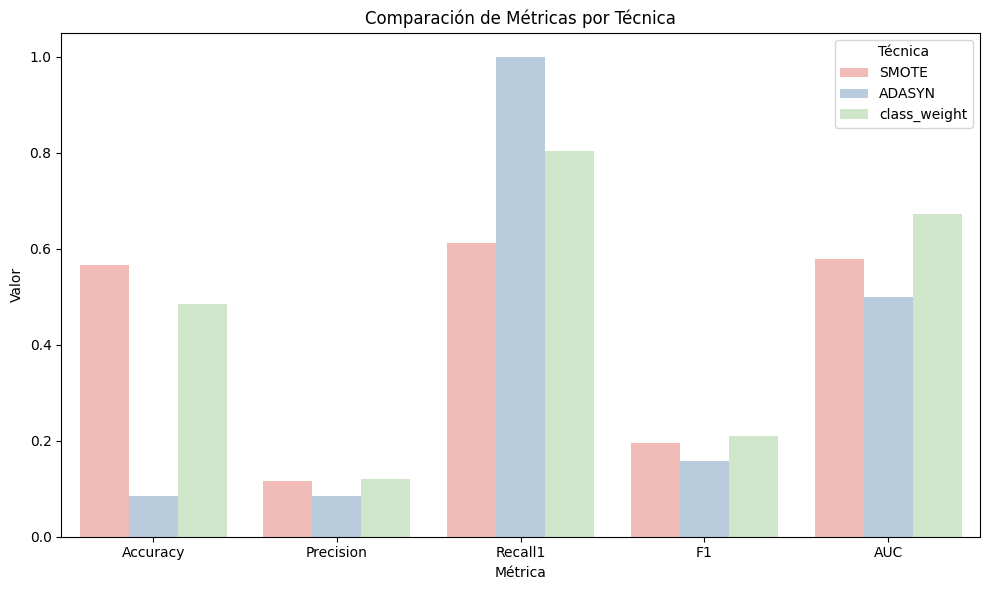

In [7]:
df_plot = df_metrics.drop(columns="fit_minutes").reset_index().melt(id_vars="index")
plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x="variable", y="value", hue="index",
    palette="Pastel1" )
plt.title("Comparaci√≥n de M√©tricas por T√©cnica")
plt.ylabel("Valor")
plt.xlabel("M√©trica")
plt.legend(title="T√©cnica")
plt.tight_layout()
plt.show()


# 8.Mapa de calor (heatmap) de m√©tricas

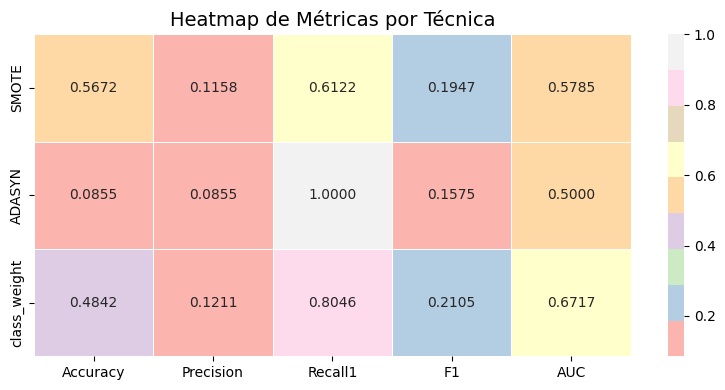

In [8]:
from matplotlib.colors import ListedColormap

# 1. Asegurar solo columnas num√©ricas
heatmap_data = df_metrics.drop(columns="fit_minutes").copy()
heatmap_data = heatmap_data.apply(pd.to_numeric, errors="coerce")

# 2. Crear un colormap basado en Pastel1
pastel_palette = sns.color_palette("Pastel1", as_cmap=True)  # colormap continuo

# 3. Dibujar heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(heatmap_data, annot=True, cmap=pastel_palette, fmt=".4f", linewidths=0.5, linecolor='white')
plt.title("Heatmap de M√©tricas por T√©cnica", fontsize=14)
plt.tight_layout()
plt.show()


# 9.Curvas ROC por t√©cnica de Balanceo

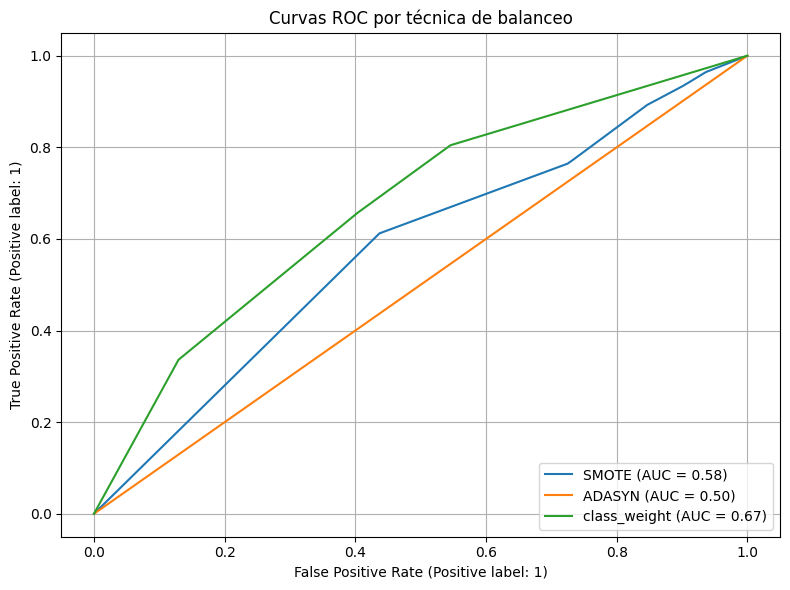

In [9]:
plt.figure(figsize=(8,6))
for name, res in results.items():
    RocCurveDisplay.from_predictions(y_test, res["y_prob"], name=name, ax=plt.gca())
plt.title("Curvas ROC por t√©cnica de balanceo")
plt.grid()
plt.tight_layout()
plt.show()


# 10.Matrices de confusi√≥n

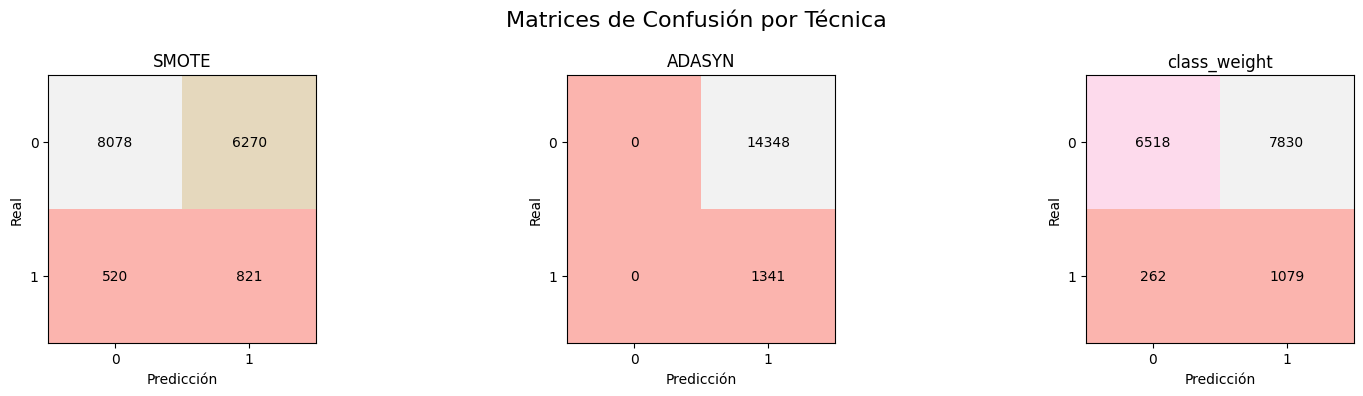

In [10]:
import matplotlib as mpl

# Crear un colormap personalizado similar a Pastel1
pastel_colors = mpl.colors.ListedColormap(sns.color_palette("Pastel1", 9).as_hex())

fig, axs = plt.subplots(1, 3, figsize=(16, 4))

for i, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(y_test, res["y_pred"])

    # Dibujar como imagen de matriz
    im = axs[i].imshow(cm, interpolation='nearest', cmap=pastel_colors)
    axs[i].set_title(name)

    # Agregar etiquetas
    tick_marks = np.arange(len(cm))
    axs[i].set_xticks(tick_marks)
    axs[i].set_yticks(tick_marks)
    axs[i].set_xlabel("Predicci√≥n")
    axs[i].set_ylabel("Real")

    # Mostrar valores en celdas
    for j in range(cm.shape[0]):
        for k in range(cm.shape[1]):
            axs[i].text(k, j, format(cm[j, k], 'd'),
                        ha="center", va="center", color="black")

plt.suptitle("Matrices de Confusi√≥n por T√©cnica", fontsize=16)
plt.tight_layout()
plt.show()


# 11.Gr√°fico Tiempo de Entrenamiento

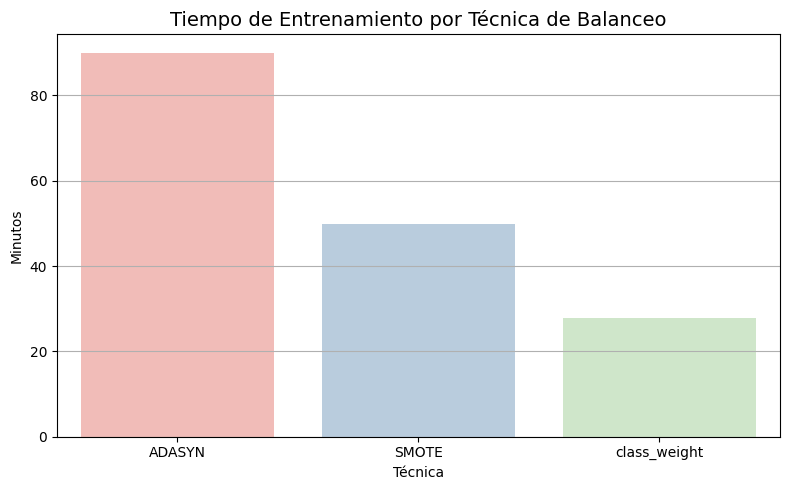

In [11]:
import warnings
warnings.filterwarnings("ignore")

# Extraer los tiempos de entrenamiento
df_tiempo = pd.DataFrame({
    "T√©cnica": list(results.keys()),
    "Tiempo (minutos)": [res["fit_minutes"] for res in results.values()]
}).sort_values(by="Tiempo (minutos)", ascending=False)

# Dibujar gr√°fico de barras
plt.figure(figsize=(8, 5))
sns.barplot(data=df_tiempo, x="T√©cnica", y="Tiempo (minutos)", palette="Pastel1")
plt.title("Tiempo de Entrenamiento por T√©cnica de Balanceo", fontsize=14)
plt.ylabel("Minutos")
plt.xlabel("T√©cnica")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


# 12.Tabla de Hiperpar√°metros √ìptimos por T√©cnica

In [12]:
# 1. Extraer mejores hiperpar√°metros
params_rows = []
for name, res in results.items():
    row = {"T√©cnica": name}
    row.update(res["grid"].best_params_)
    params_rows.append(row)

# 2. Crear DataFrame
df_params = pd.DataFrame(params_rows).set_index("T√©cnica")

# 3. Aplicar estilo visual como df_metrics
styled_params = (
    df_params.style
    .set_caption("üìå Mejores hiperpar√°metros por t√©cnica")
    .highlight_max(axis=0, color="lightgreen")  # resaltar los m√°s altos
    .format(na_rep="-")
)

display(styled_params)


TypeError: '>=' not supported between instances of 'str' and 'float'

# 13.Curva de aprendizaje (Recall1)

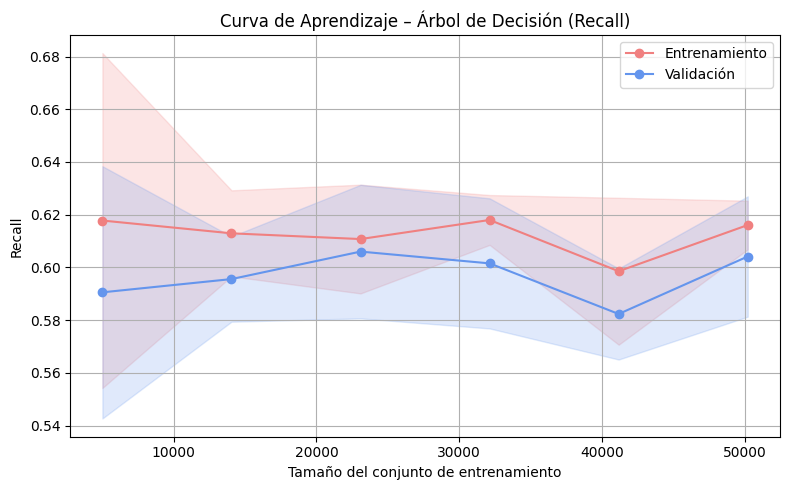

In [13]:
import warnings
from sklearn.model_selection import learning_curve

# Suprimir todos los warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import learning_curve

# Usamos el mejor pipeline (por ejemplo, con SMOTE)
pipe = results["SMOTE"]["model"]  # O el que desees

train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipe,
    X=X_train,
    y=y_train,
    cv=5,
    scoring="recall",
    train_sizes=np.linspace(0.1, 1.0, 6),
    n_jobs=14,
    shuffle=True,
    random_state=42
)

# Calcular medias
train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

# Dibujar curva
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Entrenamiento', color='lightcoral')
plt.plot(train_sizes, val_mean, 'o-', label='Validaci√≥n', color='cornflowerblue')
plt.fill_between(train_sizes, train_mean - train_scores.std(axis=1), train_mean + train_scores.std(axis=1), alpha=0.2, color='lightcoral')
plt.fill_between(train_sizes, val_mean - val_scores.std(axis=1), val_mean + val_scores.std(axis=1), alpha=0.2, color='cornflowerblue')

plt.title("Curva de Aprendizaje ‚Äì √Årbol de Decisi√≥n (Recall)")
plt.xlabel("Tama√±o del conjunto de entrenamiento")
plt.ylabel("Recall")
plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.show()


# 14.Curvas Precision-Recall


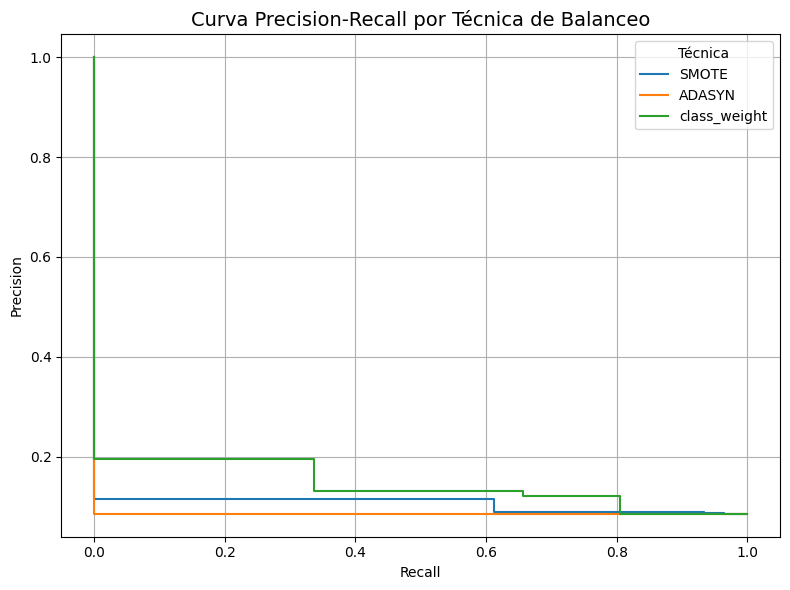

In [14]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

plt.figure(figsize=(8, 6))

for name, res in results.items():
    precision, recall, _ = precision_recall_curve(y_test, res["y_prob"])
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot(ax=plt.gca(), name=name)

plt.title("Curva Precision-Recall por T√©cnica de Balanceo", fontsize=14)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend(title="T√©cnica")
plt.tight_layout()
plt.show()


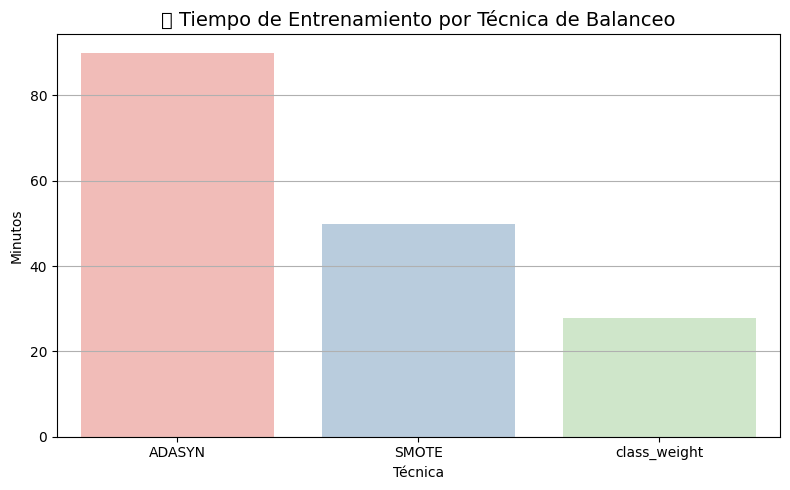

In [15]:
# Extraer los tiempos de entrenamiento
df_tiempo = pd.DataFrame({
    "T√©cnica": list(results.keys()),
    "Tiempo (minutos)": [res["fit_minutes"] for res in results.values()]
}).sort_values(by="Tiempo (minutos)", ascending=False)

# Dibujar gr√°fico de barras
plt.figure(figsize=(8, 5))
sns.barplot(data=df_tiempo, x="T√©cnica", y="Tiempo (minutos)", palette="Pastel1")
plt.title("‚è±Ô∏è Tiempo de Entrenamiento por T√©cnica de Balanceo", fontsize=14)
plt.ylabel("Minutos")
plt.xlabel("T√©cnica")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


# 15.Estructura del Arbol

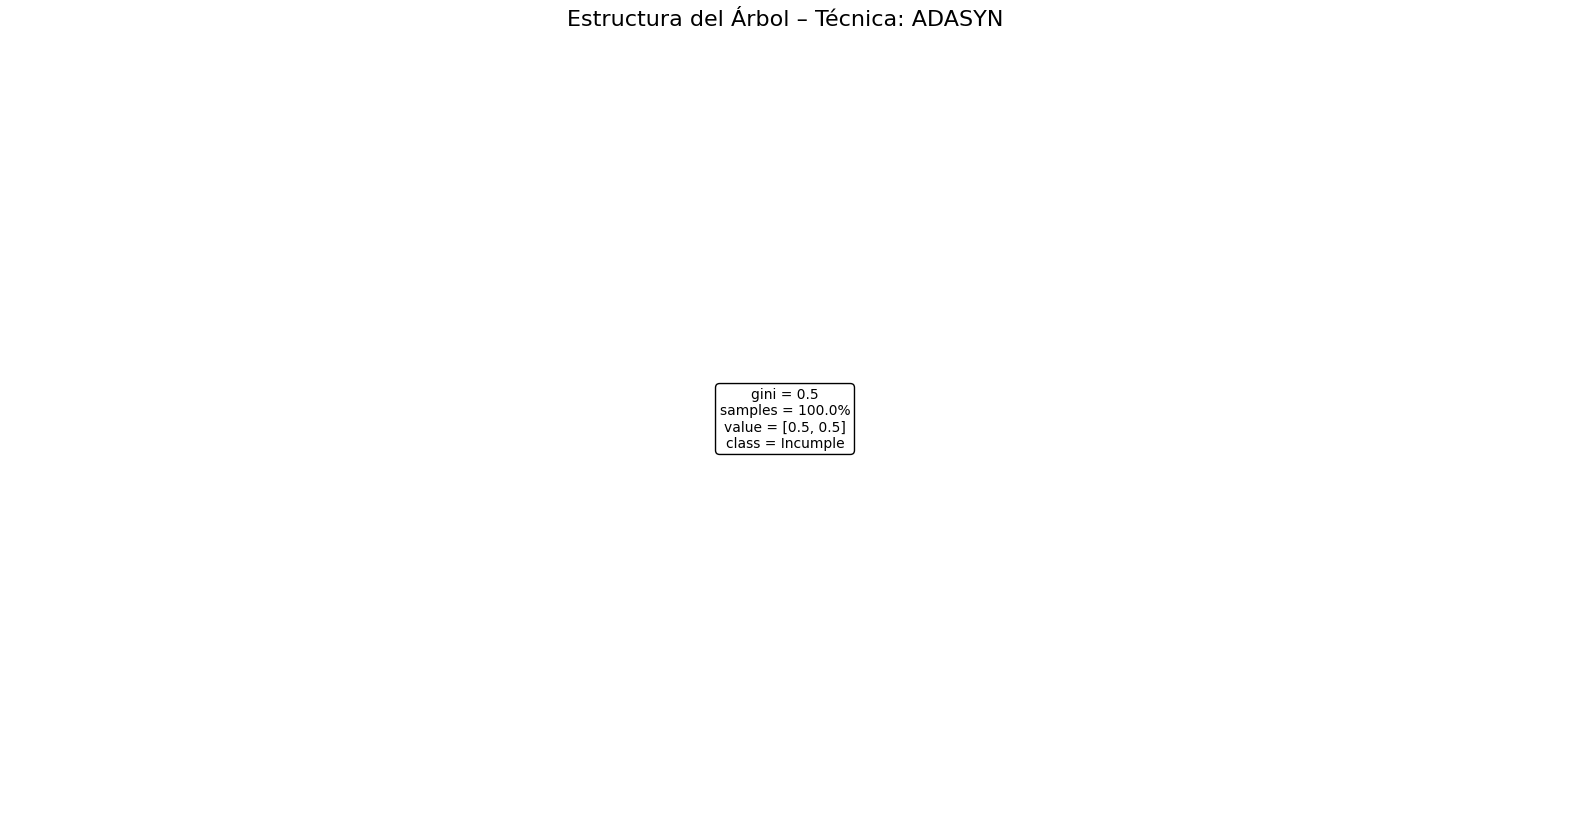

In [16]:
from sklearn.tree import plot_tree
from matplotlib.colors import ListedColormap

# Paleta Pastel1 (9 colores disponibles)
pastel_colors = sns.color_palette("Pastel1", 9).as_hex()

# Elegir el modelo con mayor Recall1
mejor_tecnica = df_metrics["Recall1"].idxmax()
mejor_modelo = results[mejor_tecnica]["model"]

# Extraer el clasificador
clf = mejor_modelo.named_steps["clf"] if "clf" in mejor_modelo.named_steps else mejor_modelo.named_steps["classifier"]

# Asignar estilo general
plt.figure(figsize=(20, 10))
plot_tree(
    clf,
    max_depth=3,
    filled=True,
    fontsize=10,
    feature_names=None,
    impurity=True,
    class_names=["No Incumple", "Incumple"],
    proportion=True,
    rounded=True
)

# Aplicar t√≠tulo
plt.title(f"Estructura del √Årbol ‚Äì T√©cnica: {mejor_tecnica}", fontsize=16)

# Cambiar colores de fondo del gr√°fico a tonos suaves
ax = plt.gca()
for box in ax.patches:
    box.set_facecolor(np.random.choice(pastel_colors))  # colores pastel aleatorios

plt.show()


# 16.Heatmap de Recall1 por T√©cnica y Penalizaci√≥n

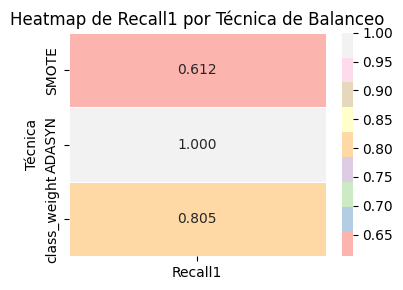

In [17]:
import warnings
warnings.filterwarnings("ignore")

# Construir DataFrame con Recall1 por t√©cnica
df_heat = pd.DataFrame([
    {
        "T√©cnica": name,
        "Recall1": res["Recall1"]
    }
    for name, res in results.items()
])

# Reorganizar para heatmap (una sola columna)
df_heat.set_index("T√©cnica", inplace=True)

# Dibujar heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(
    df_heat,
    annot=True,
    fmt=".3f",
    cmap=sns.color_palette("Pastel1", as_cmap=True),
    linewidths=0.5,
    linecolor="white"
)
plt.title("Heatmap de Recall1 por T√©cnica de Balanceo", fontsize=12)
plt.tight_layout()
plt.show()


# 17.Radar Plot por modelo para comparar m√©tricas

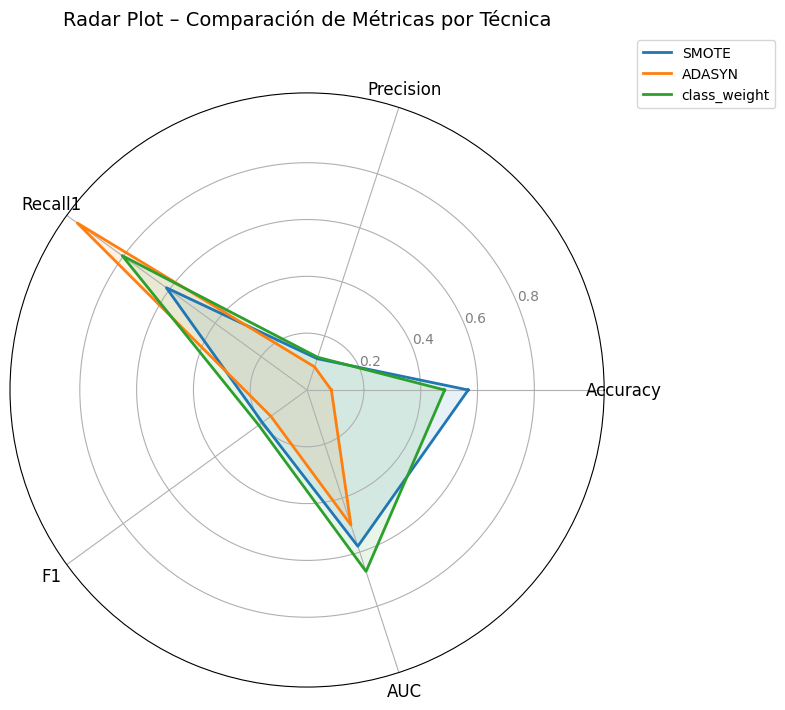

In [18]:
from math import pi

# 1. Prepara los datos
df_radar = df_metrics.drop(columns="fit_minutes").copy()
df_radar.index.name = "T√©cnica"
df_radar = df_radar.reset_index()

# 2. Ejes del radar
metrics = df_radar.columns[1:]  # columnas: Accuracy, Precision, Recall1, F1, AUC
N = len(metrics)

# 3. √Ångulos para cada m√©trica
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # cerrar el c√≠rculo

# 4. Inicializar figura
plt.figure(figsize=(8, 8))
plt.subplot(111, polar=True)

# 5. Dibujar por t√©cnica
for i in range(len(df_radar)):
    values = df_radar.iloc[i, 1:].values.tolist()
    values += values[:1]  # cerrar la figura
    plt.plot(angles, values, label=df_radar.iloc[i, 0], linewidth=2)
    plt.fill(angles, values, alpha=0.1)

# 6. Estilo del radar
plt.xticks(angles[:-1], metrics, fontsize=12)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="gray", size=10)
plt.title("Radar Plot ‚Äì Comparaci√≥n de M√©tricas por T√©cnica", size=14, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


# 9. Guardar modelos entrenado

In [23]:
import joblib
import os
import re

# Funci√≥n para limpiar nombres de archivo
def limpiar_nombre(nombre):
    return re.sub(r'[^\w\-_.]', '_', nombre)

# Ruta del escritorio
desktop_path = os.path.join(os.environ["USERPROFILE"], "Desktop")
base_folder_name = "modelos_guardados"
model_dir = os.path.join(desktop_path, base_folder_name)

# Evitar sobrescribir carpeta
counter = 1
while os.path.exists(model_dir):
    model_dir = os.path.join(desktop_path, f"{base_folder_name}_{counter}")
    counter += 1
os.makedirs(model_dir)

# Guardar modelos
for metodo, res in results.items():
    metodo_limpio = limpiar_nombre(metodo)
    nombre_archivo = os.path.join(model_dir, f"{metodo_limpio}.joblib")
    
    if "model" in res:
        joblib.dump(res["model"], nombre_archivo)
    else:
        print(f"‚ö†Ô∏è  No se encontr√≥ modelo en: {metodo}")

print(f"\n‚úÖ Modelos guardados exitosamente en: {model_dir}")



‚úÖ Modelos guardados exitosamente en: C:\Users\DELL\Desktop\modelos_guardados_2
